In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import statsmodels.api as sm
import os
from datetime import date, datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('BrainTumor.csv')

In [3]:
df.head(10)

,Patient ID,Age,Gender,Tumor Type,Tumor Grade,Tumor Location,Treatment,Treatment Outcome,Time to Recurrence (months),Recurrence Site,Survival Time (months)
0,1,45,Male,Glioblastoma,IV,Frontal lobe,Surgery,Partial response,10.0,Temporal lobe,18
1,2,55,Female,Meningioma,I,Parietal lobe,Surgery,Complete response,NaN,NaN,36
2,3,60,Male,Astrocytoma,III,Occipital lobe,Surgery + Chemotherapy,Progressive disease,14.0,Frontal lobe,22
3,4,50,Female,Glioblastoma,IV,Temporal lobe,Surgery + Radiation therapy,Complete response,NaN,NaN,12
4,5,65,Male,Astrocytoma,II,Frontal lobe,Surgery + Radiation therapy,Partial response,24.0,Frontal lobe,48
5,6,45,Male,Glioblastoma,IV,Frontal lobe,Surgery,Partial response,10.0,Temporal lobe,18
6,7,55,Female,Meningioma,I,Parietal lobe,Surgery,Complete response,NaN,NaN,36
7,8,60,Male,Astrocytoma,III,Occipital lobe,Surgery + Chemotherapy,Progressive disease,14.0,Frontal lobe,22
8,9,50,Female,Glioblastoma,IV,Temporal lobe,Surgery + Radiation,Complete response,NaN,NaN,12
9,10,65,Male,Astrocytoma,II,Frontal lobe,Surgery + Radiation,Partial response,24.0,Frontal lobe,48


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Patient ID,2000.0,1000.500000,577.494589,1.0,500.75,1000.5,1500.25,2000.0
Age,2000.0,56.153000,6.078492,42.0,51.00,56.0,61.00,72.0
Time to Recurrence (months),1438.0,16.099444,3.128291,6.0,14.00,16.0,18.00,36.0
Survival Time (months),2000.0,34.270000,8.606343,9.0,28.00,36.0,42.00,72.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Patient ID                   2000 non-null   int64  
 1   Age                          2000 non-null   int64  
 2   Gender                       2000 non-null   object 
 3   Tumor Type                   2000 non-null   object 
 4   Tumor Grade                  2000 non-null   object 
 5   Tumor Location               2000 non-null   object 
 6   Treatment                    2000 non-null   object 
 7   Treatment Outcome            2000 non-null   object 
 8   Time to Recurrence (months)  1438 non-null   float64
 9   Recurrence Site              1438 non-null   object 
 10  Survival Time (months)       2000 non-null   int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 172.0+ KB


In [7]:
df.isnull().sum(axis=0)

Patient ID                       0
Age                              0
Gender                           0
Tumor Type                       0
Tumor Grade                      0
Tumor Location                   0
Treatment                        0
Treatment Outcome                0
Time to Recurrence (months)    562
Recurrence Site                562
Survival Time (months)           0
dtype: int64

In [8]:
df['Recurrence Site'].fillna('Unknown', inplace=True)

fnc = [np.nanmedian, np.nanmean]
name = ['Median', 'Mean']

for func, name in zip(fnc, name):
    print('=============Time to Recurrence (Months)============')
    col = func(df['Time to Recurrence (months)'])
    print(f'{name} - {col}')

=============Time to Recurrence (Months)============
Median - 16.0
=============Time to Recurrence (Months)============
Mean - 16.09944367176634


In [9]:
df['Time to Recurrence (months)'].fillna(df['Time to Recurrence (months)'].mean(), inplace=True)

In [10]:
data = pd.get_dummies(df, dtype=int)

X = data.drop(columns=['Survival Time (months)','Patient ID'])
y = data['Survival Time (months)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Initialize the models
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

In [13]:
best_model_name = None
best_model = None
best_score = -np.inf

In [14]:
 # Train each model and evaluate its performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f'{name} R² score: {score}')
    
    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model
        best_y_pred = y_pred

print(f'\nBest model: {best_model_name} with R² score: {best_score}')

Decision Tree R² score: 0.7908612013623972
Random Forest R² score: 0.834239309234259
XGBoost R² score: 0.8207888132059589

Best model: Random Forest with R² score: 0.834239309234259


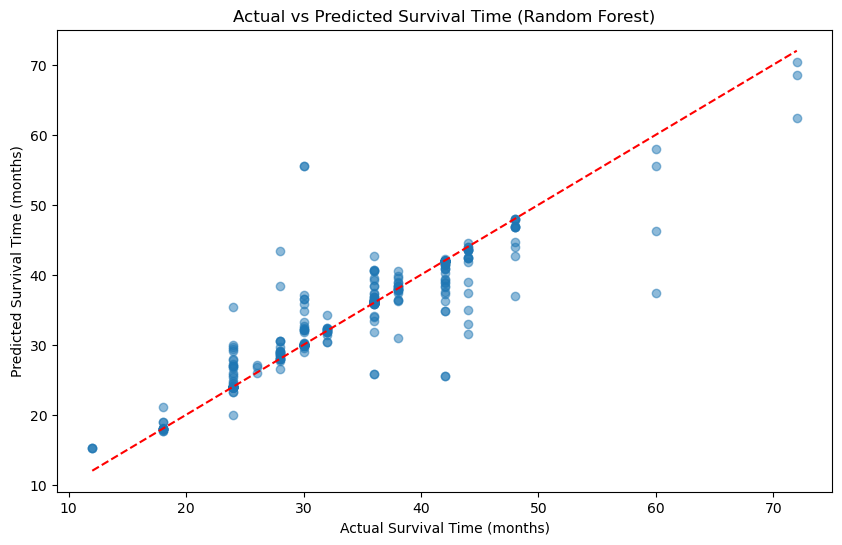

In [15]:
# Plotting the actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line for reference
plt.xlabel('Actual Survival Time (months)')
plt.ylabel('Predicted Survival Time (months)')
plt.title(f'Actual vs Predicted Survival Time ({best_model_name})')
plt.show()

In [17]:
silhouette_scores = []
range_n_clusters = range(2, 11) 

In [18]:
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append((n_clusters, silhouette_avg))
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}')

Number of clusters: 2, Silhouette Score: 0.4307682871181834
Number of clusters: 3, Silhouette Score: 0.31750818073109704
Number of clusters: 4, Silhouette Score: 0.26356454301011273
Number of clusters: 5, Silhouette Score: 0.26753327475896466
Number of clusters: 6, Silhouette Score: 0.2500913443236559
Number of clusters: 7, Silhouette Score: 0.25156248503150747
Number of clusters: 8, Silhouette Score: 0.24830838355460627
Number of clusters: 9, Silhouette Score: 0.2595736353467407
Number of clusters: 10, Silhouette Score: 0.2567543366171371


In [19]:
# Select the optimal number of clusters
optimal_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]
print(f'Optimal number of clusters: {optimal_n_clusters}')

Optimal number of clusters: 2


In [20]:
# Perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)


In [21]:
# Add the cluster assignments as a new feature
X['Cluster'] = clusters

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Initialize the models
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

best_model_name = None
best_model = None
best_score = -np.inf

In [23]:
 # Train each model and evaluate its performance
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f'{name} R² score: {score}')
    
    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model
        best_y_pred = y_pred

print(f'\nBest model: {best_model_name} with R² score: {best_score}')

Decision Tree R² score: 0.7831277460414523
Random Forest R² score: 0.8310858131538816
XGBoost R² score: 0.8207888132059589

Best model: Random Forest with R² score: 0.8310858131538816


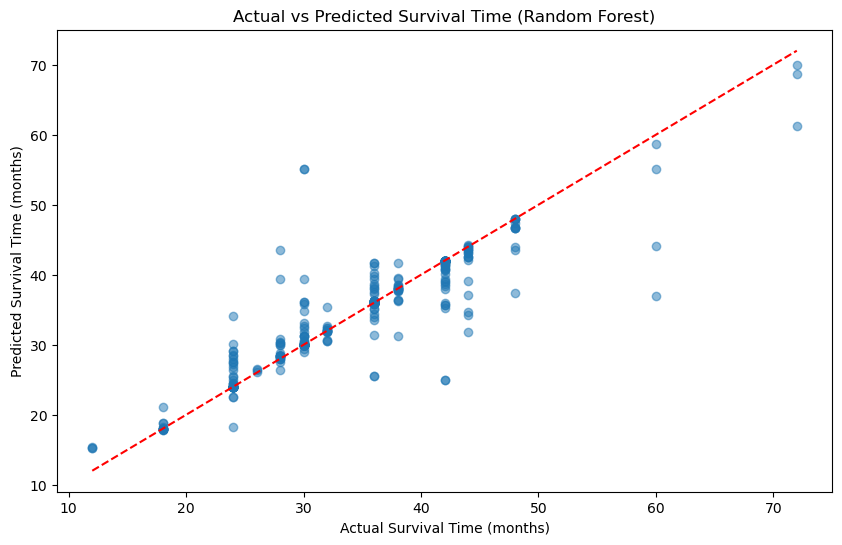

In [24]:
# Plotting the actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line for reference
plt.xlabel('Actual Survival Time (months)')
plt.ylabel('Predicted Survival Time (months)')
plt.title(f'Actual vs Predicted Survival Time ({best_model_name})')
plt.show()

In [25]:
# Convert categorical variables to dummy/indicator variables
data = pd.get_dummies(df, dtype=int)

# Separate features (X) and target (y)
X = data.drop(columns=['Survival Time (months)', 'Patient ID'])
y = data['Survival Time (months)']

In [26]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [28]:
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [29]:
best_rf = grid_search.best_estimator_
print(f'Best Random Forest parameters: {grid_search.best_params_}')

Best Random Forest parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [30]:
# Train and evaluate the Random Forest model with the best parameters
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
score = r2_score(y_test, y_pred)
print(f'Random Forest R² score: {score}')

Random Forest R² score: 0.8334208529141143


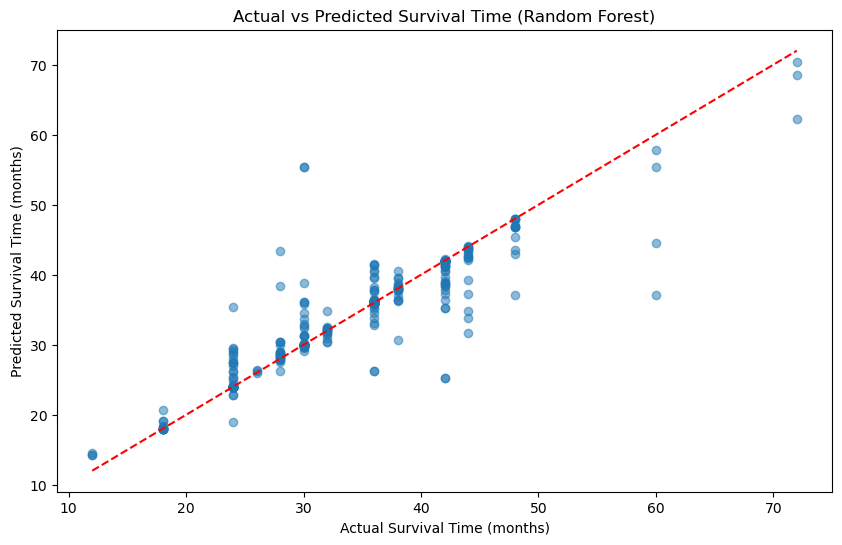

In [31]:
# Plotting the actual vs predicted values for the Random Forest model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line for reference
plt.xlabel('Actual Survival Time (months)')
plt.ylabel('Predicted Survival Time (months)')
plt.title(f'Actual vs Predicted Survival Time (Random Forest)')
plt.show()

In [32]:
# Extract and visualize feature importances for the Random Forest model
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

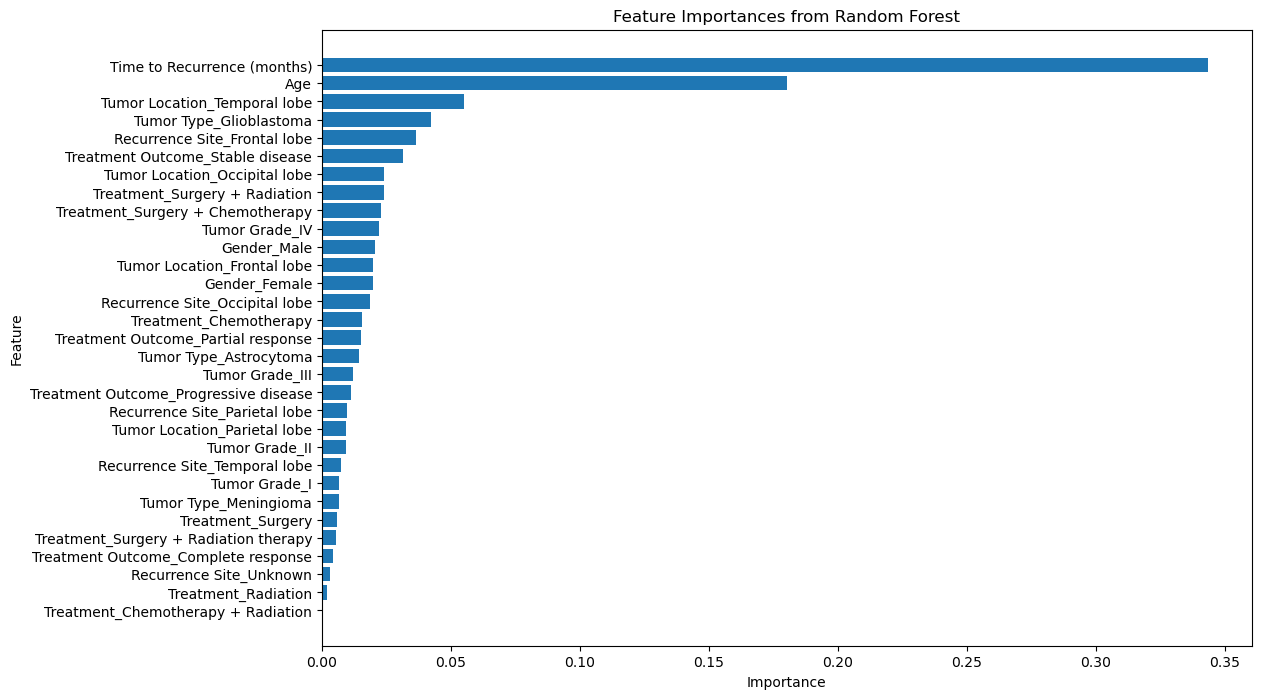

In [33]:
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()